In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../input/train.csv')
test  = pd.read_csv('../input/test.csv')

In [3]:
i = 1
for df in [test, train]:
    idx = df.columns.values[i:i+200]
    df['sum']  = df[idx].sum(axis=1)  
    df['min']  = df[idx].min(axis=1)
    df['max']  = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std']  = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med']  = df[idx].median(axis=1)
    i = i + 1

In [4]:
# thank you 
# https://www.kaggle.com/jiweiliu/lgb-2-leaves-augment

def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [5]:
train = santander_data
X_test = santander_data_test
del santander_data
del santander_data_test
gc.collect()

NameError: name 'santander_data' is not defined

In [6]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [7]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 28,
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1}

In [8]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=31415)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 15000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.900302	valid_1's auc: 0.88392
[2000]	training's auc: 0.911135	valid_1's auc: 0.891262
[3000]	training's auc: 0.918772	valid_1's auc: 0.895226
[4000]	training's auc: 0.924603	valid_1's auc: 0.897522
[5000]	training's auc: 0.929488	valid_1's auc: 0.898883
[6000]	training's auc: 0.933792	valid_1's auc: 0.899768
[7000]	training's auc: 0.937819	valid_1's auc: 0.900191
Early stopping, best iteration is:
[7603]	training's auc: 0.940047	valid_1's auc: 0.900402
Fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.900488	valid_1's auc: 0.878733
[2000]	training's auc: 0.911602	valid_1's auc: 0.887613
[3000]	training's auc: 0.919089	valid_1's auc: 0.892405
[4000]	training's auc: 0.924878	valid_1's auc: 0.895536
[5000]	training's auc: 0.929882	valid_1's auc: 0.897419
[6000]	training's auc: 0.934078	valid_1's auc: 0.89848
[7000]	training's auc: 0.938047	valid_1's a

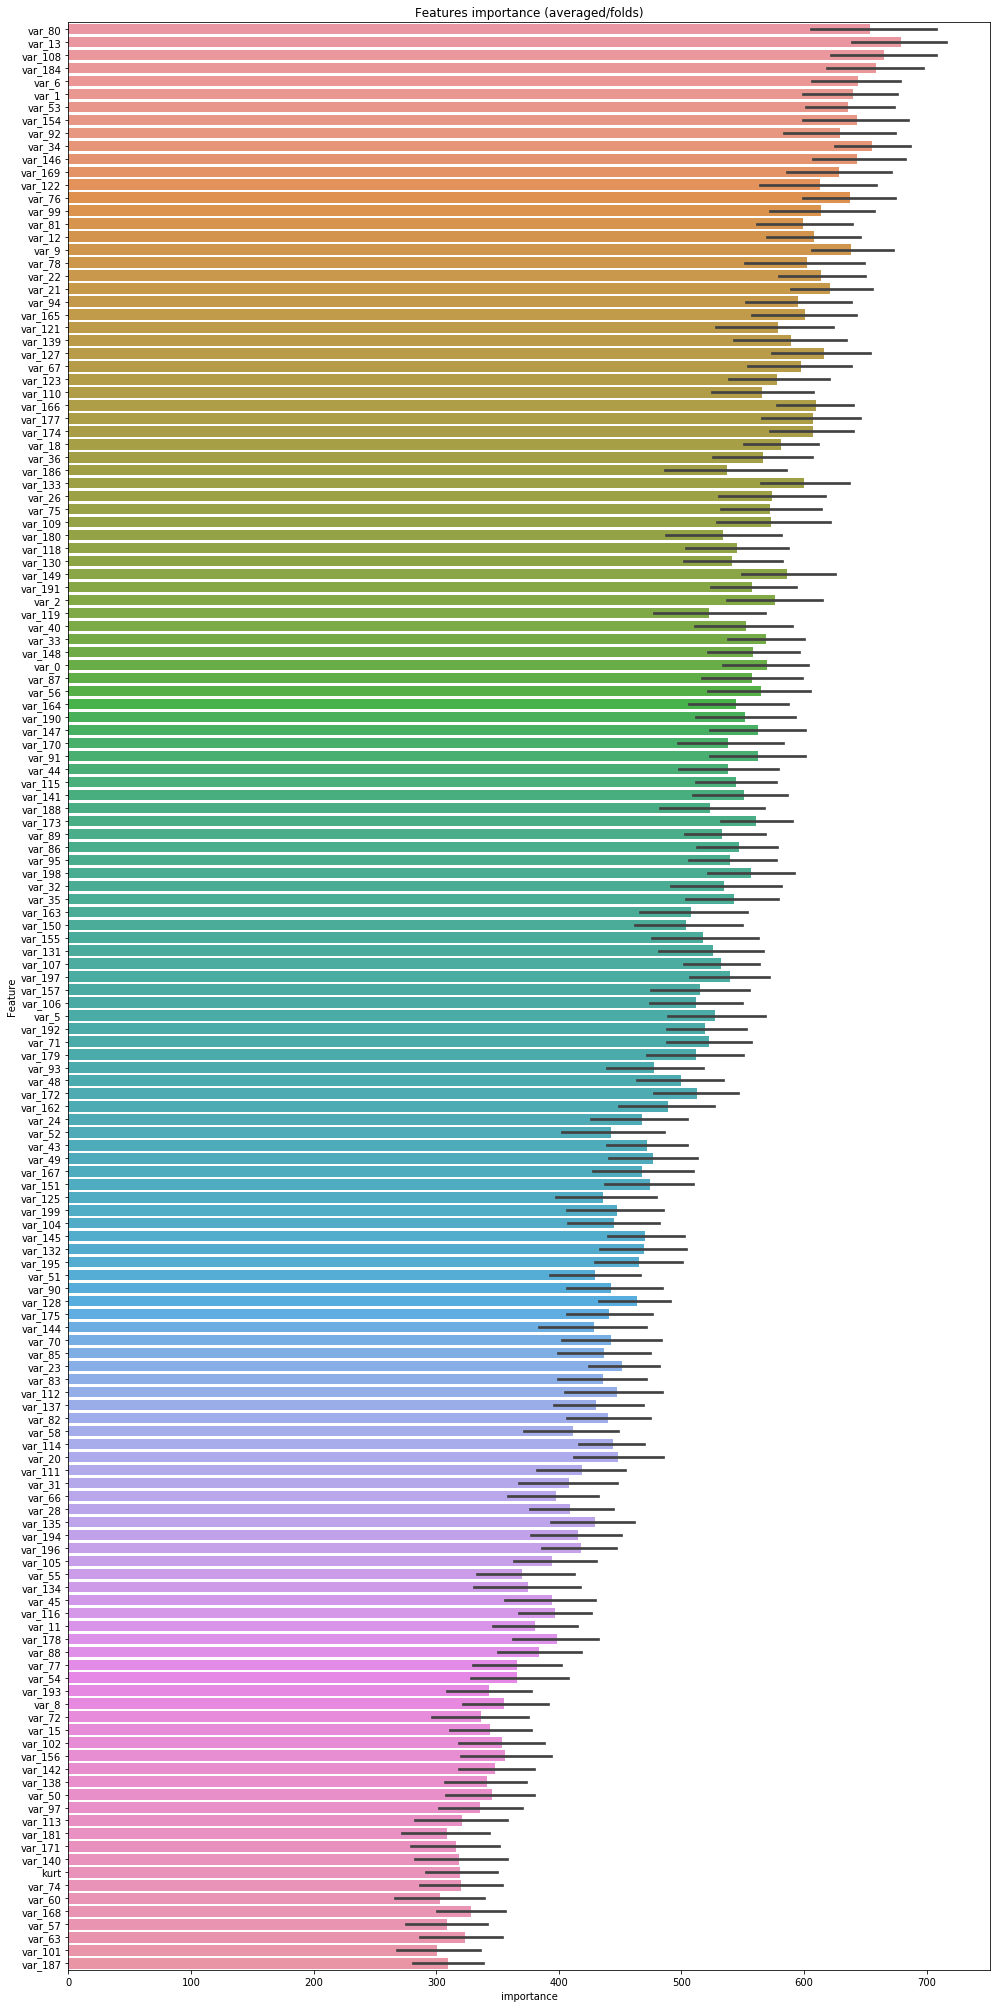

In [9]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [10]:
sub_df = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("submission.csv", index=False)

In [11]:
## Catboost : https://www.kaggle.com/wakamezake/starter-code-catboost-baseline
from catboost import Pool, CatBoostClassifier
model = CatBoostClassifier(loss_function="Logloss", eval_metric="AUC")
kf = KFold(n_splits=10, random_state=42, shuffle=True)

y_valid_pred = 0 * target
y_test_pred = 0

for idx, (train_index, valid_index) in enumerate(kf.split(train)):
    y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
    X_train, X_valid = train[features].iloc[train_index,:], train[features].iloc[valid_index,:]
    _train = Pool(X_train, label=y_train)
    _valid = Pool(X_valid, label=y_valid)
    print( "\nFold ", idx)
    fit_model = model.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=200
                         )
    pred = fit_model.predict_proba(X_valid)[:,1]
    print( "  auc = ", roc_auc_score(y_valid, pred) )
    y_valid_pred.iloc[valid_index] = pred
    y_test_pred += fit_model.predict_proba(test[features])[:,1]
y_test_pred /= 5


Fold  0
Learning rate set to 0.134603
0:	test: 0.5458949	best: 0.5458949 (0)	total: 504ms	remaining: 8m 23s
200:	test: 0.8854766	best: 0.8854766 (200)	total: 1m 5s	remaining: 4m 21s
400:	test: 0.8936483	best: 0.8936657 (389)	total: 2m 13s	remaining: 3m 19s
600:	test: 0.8958046	best: 0.8958084 (594)	total: 3m 19s	remaining: 2m 12s
800:	test: 0.8964003	best: 0.8965118 (758)	total: 4m 25s	remaining: 1m 5s
999:	test: 0.8970795	best: 0.8971697 (973)	total: 5m 28s	remaining: 0us

bestTest = 0.8971696785
bestIteration = 973

Shrink model to first 974 iterations.
  auc =  0.8971696785419386

Fold  1
Learning rate set to 0.134603
0:	test: 0.5368812	best: 0.5368812 (0)	total: 406ms	remaining: 6m 45s
200:	test: 0.8808995	best: 0.8808995 (200)	total: 1m 3s	remaining: 4m 13s
400:	test: 0.8897347	best: 0.8897347 (400)	total: 2m 8s	remaining: 3m 11s
600:	test: 0.8918142	best: 0.8918377 (597)	total: 3m 12s	remaining: 2m 7s
800:	test: 0.8927364	best: 0.8928143 (795)	total: 4m 15s	remaining: 1m 3s
999:

In [12]:
##submission
sub_df1 = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df1["target"] = y_test_pred
sub_df1.to_csv("cat_submission.csv", index=False)

In [13]:
sub_df2 = pd.DataFrame({"ID_code":test["ID_code"].values})
sub_df2["target"] = 0.5*sub_df["target"] + 0.5*sub_df1["target"]
sub_df2.to_csv("lgb_cat_submission.csv", index=False)